<a href="https://colab.research.google.com/github/Benjamin-morel/TensorFlow/blob/main/04_convolution_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

# **Machine Learning Model: Convolutional Neural Network**

| | |
|------|------|
| Filename | 04_convolution_CNN.ipynb |
| Author(s) | Benjamin Morel (benjaminmorel27@gmail.com) |
| Date | September 10, 2024 |
| Aim(s) | Classify images with a simple convolutional neural network |
| Dataset(s) | Flower API Google dataset |
| Version | Python 3.12 - TensorFlow 2.17.0|


<br> **!!Read before running!!** <br>
1. Fill in the inputs
2. CPU execution is enough.
3. Run all and read comments.

---

#### **Motivation**

A **convolutional neural network** (CNN) model is created and trained in this Python script. The objective is to classify 5 different flower classes from the Google API flower dataset.

#### **Outline**
For this, a serie of **convolution blocks** with a **max pooling** layer are added to a neural network. In a second part of the code, the recurrent problem of **overfitting** in image classification is partially solved by adding layer dropout and **data augmentation**.

---


#### **0. Input section**

The model has already been trained: **parameters** (weights and biases) of each neuron are already known according to the base dataset. The user can choose to keep these parameters and **not retrain the model** (No), or he can decide to repeat the **training phase** (Yes). Using a pre-trained model saves time, computer resources and CO2 emissions.

In [ ]:
training_phase = 'No'

---


#### **1. Import libraries & prebuilt dataset**


###### **1.1. Python libraries and functions**



In [ ]:
from numpy import array, argmax, max
from os import path
from PIL import Image # image processing capabilities
from tensorflow import keras, data, expand_dims, nn
from keras import layers, utils, Sequential, Input, losses, callbacks
import matplotlib.pyplot as plt

Two graphic functions are declared below:


*   `plot_image`: plot an image with the label as title
*   `plot_evolution`: plot the loss/accuracy value obtained from one dataset at each epoch



In [ ]:
def plot_image(image, *label):
  plt.imshow(image)
  plt.title("%s" %label)
  image = plt.axis("off")
  return image

In [ ]:
def plot_evolution(history):
  loss_train, loss_val = history[0], history[2]
  acc_train, acc_val = history[1], history[3]
  epochs = range(1, len(acc_train) + 1)

  fig = plt.subplot(2,1,1)
  plt.plot(epochs, loss_train, label='Training', color='blue')
  plt.plot(epochs, loss_val, label='Validation', color='orange')
  plt.legend(loc='best', fontsize=10)
  plt.grid(True, linestyle='--', alpha=0.6), plt.ylabel('Loss', fontsize=12)

  plt.subplot(2,1,2)
  plt.plot(epochs, acc_train, color='blue')
  plt.plot(epochs, acc_val, color='orange')
  plt.xlabel('Epochs', fontsize=12), plt.ylabel('Accuracy', fontsize=12)
  plt.grid(True, linestyle='--', alpha=0.6)

###### **1.2. Retrieve data**

The flower Google API dataset is composed of 3,670 photos of flowers labelled in 5 classes: rose, dandelion, tulip, sunflower and daisy. Each input is composed of 180x180 pixels and a triplet of values defining the rgd code is associated with each pixel.

In [ ]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = utils.get_file('flower_photos', dataset_url, untar=True)
data_dir = path.join(path.dirname(data_dir), 'flower_photos')

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


###### **1.3. Batch generation**

From the 3670 photos, it is essential to build training, validation and test sets. In view of the small size of the data set, the test set will be of little consequence. Hence the distribution of the sets:


*   80% for the training set ≈ 92 batches of 32 pictuires
*   16% for the validation set ≈ 19 batches
*   4% for the test set ≈ 4 batches



In [ ]:
batch_size, img_height, img_width = 32, 180, 180
train_ds = utils.image_dataset_from_directory(data_dir, validation_split=0.2, subset="training", seed=123, image_size=(img_height, img_width), batch_size=batch_size)
val_ds = utils.image_dataset_from_directory(data_dir, validation_split=0.2, subset="validation", seed=123, image_size=(img_height, img_width), batch_size=batch_size)

class_names = train_ds.class_names

val_ds_batch = data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_ds_batch // 5) # create a test set from 20% of the validation set
val_ds = val_ds.skip(val_ds_batch // 5)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
print("# of training batches: %d" %data.experimental.cardinality(train_ds), "\n# of test batches: %d" %data.experimental.cardinality(test_ds), "\n# of validation batches: %d" %data.experimental.cardinality(val_ds))

# of training batches: 92 
# of test batches: 4 
# of validation batches: 19


###### **1.4. Data inspection**

As can be seen with the function `plot_image`, the flower data are very varied and rather noisy (presence of decorative elements, human, grave...). We must be careful that these noises do not become features of the flowers.

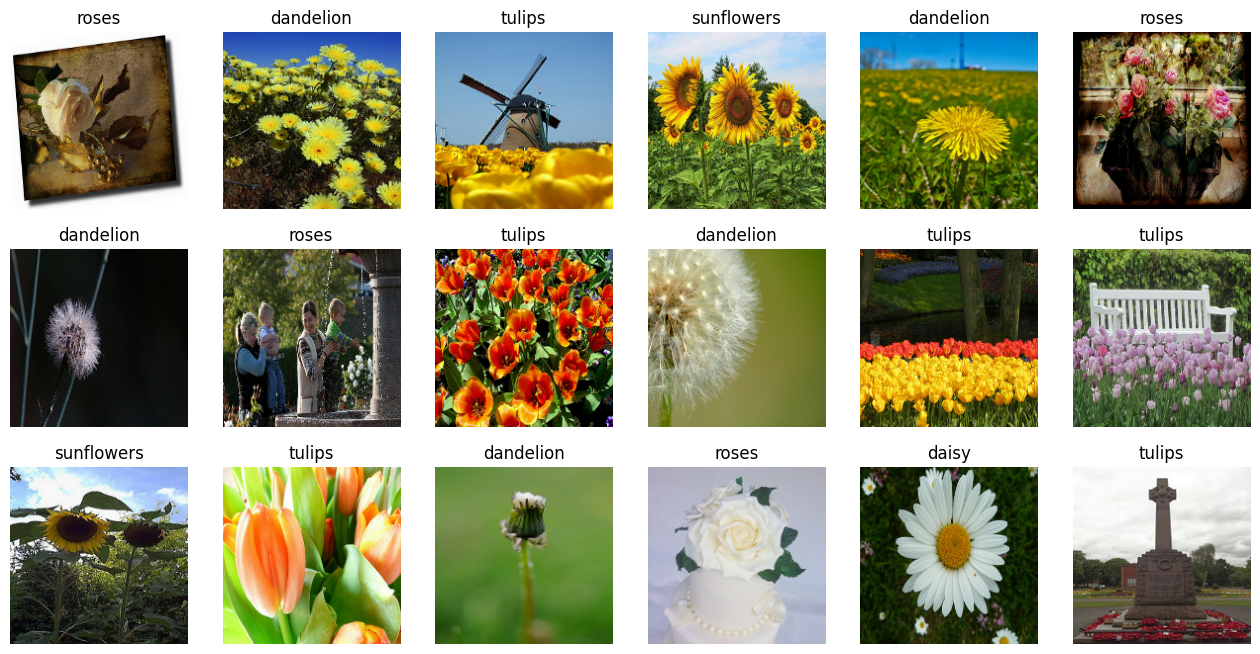

In [ ]:
plt.figure(figsize=(16, 8))
for images, labels in train_ds.take(1):
  tensor_images, tensor_labels = images, labels
  for i in range(18):
    ax = plt.subplot(3, 6, i + 1)
    plot_image(images[i].numpy().astype("uint8"), class_names[labels[i]])

###### **1.5. Performance data configuration**

The following section is used to store data temporarily in the RAM (`cache` function) and to load the next batch in background with a prefetch buffer size computed by AUTOTUNE (`prefetch` function).

In [ ]:
AUTOTUNE = data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

---


#### **2. Model and training**

###### **2.1. Data augmentation**

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),], name="data_augmentation_layer")

images_modified = data_augmentation(tensor_images) # apply to the example set

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


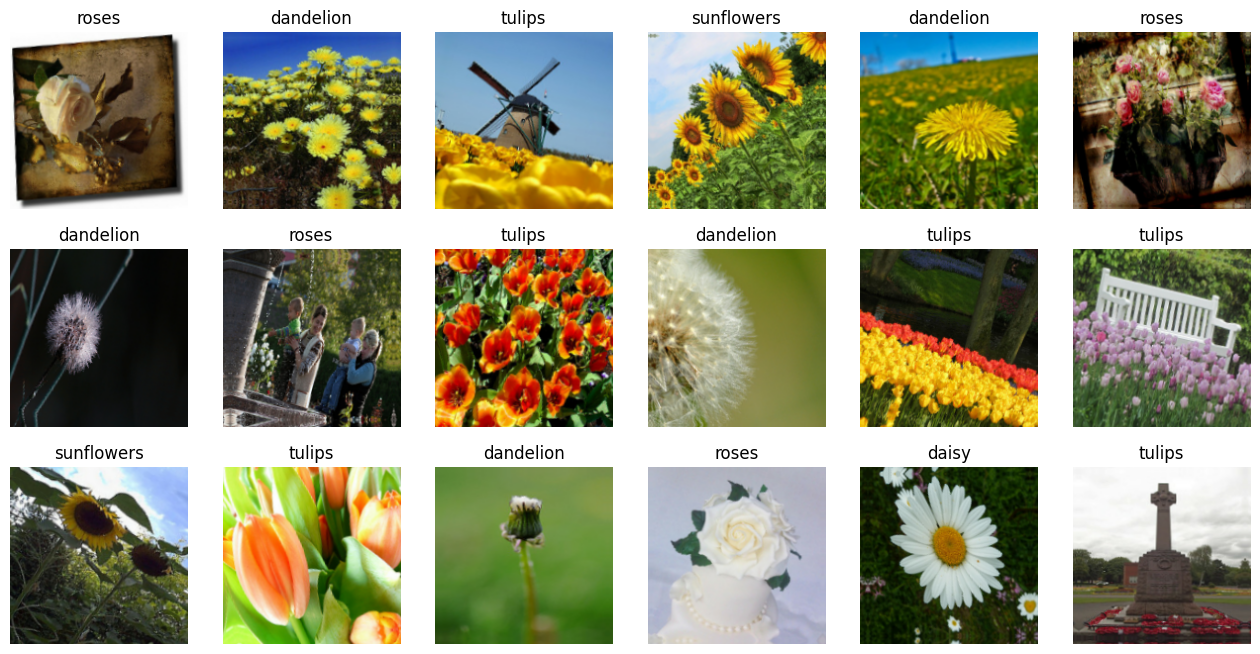

In [ ]:
plt.figure(figsize=(16, 8))
for i in range(18):
  ax = plt.subplot(3, 6, i + 1)
  plot_image(images_modified[i].numpy().astype("uint8"), class_names[tensor_labels[i]])

###### **2.2. Model definition**

In [ ]:
def create_model():
  num_classes = len(class_names)

  model = Sequential([
      data_augmentation,
      layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(0.2),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(num_classes)
  ], name="Sequential_1")

  model.compile(optimizer='adam',
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[keras.metrics.SparseCategoricalAccuracy()])
  return model

###### **2.3. Model training**

In [ ]:
def train_model(model, training_data, validation_data, **kwargs):
  kwargs.setdefault("epochs", 5)
  kwargs.setdefault("verbose", 1)
  log = model.fit(training_data, validation_data=validation_data, validation_freq=1, callbacks=[stop_early, cp_callback], **kwargs)

  return log.history["loss"], log.history["sparse_categorical_accuracy"], log.history["val_loss"], log.history["val_sparse_categorical_accuracy"]

In [ ]:
model = create_model()
epochs = 20

if training_phase == "Yes":
  stop_early = callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=5, restore_best_weights=True, min_delta=0.001)
  cp_callback = callbacks.ModelCheckpoint(filepath='04_convolution_CNN.keras',
                                          monitor = "val_sparse_categorical_accuracy",
                                          save_best_only = True,
                                          mode = "max",
                                          save_weights_only=False,
                                          verbose=0)
  classifier_accuracy = train_model(model, train_ds, val_ds, epochs=epochs)
  print("Accuracy max %0.1f %% reached at the epoch %d" %(100*max(classifier_accuracy[3]), argmax(classifier_accuracy[3])+1))

###### **2.4. Model evaluation and comments**

In [ ]:
if training_phase == 'Yes':
  plot_evolution(classifier_accuracy)

In [ ]:
model = keras.models.load_model('04_convolution_CNN.keras')

In [ ]:
loss_test, accuracy_test = model.evaluate(test_ds, verbose=0)
print("Test loss function value %0.1f and test accuracy value %0.1f %%" %(loss_test, 100*accuracy_test))

Test loss function value 0.8 and test accuracy value 68.0 %


---


#### **3. Predictions and generalization**

In [ ]:
!git clone https://github.com/Benjamin-morel/TensorFlow.git # go to the Github repertory TensorFlow and clone it
tulip = Image.open("TensorFlow/99_pre_trained_models/tulip.jpeg")
rose = Image.open("TensorFlow/99_pre_trained_models/rose.jpeg")
daisy = Image.open("TensorFlow/99_pre_trained_models/daisy.jpeg")
sunflowers = Image.open("TensorFlow/99_pre_trained_models/sunflowers.jpeg")
bouquet = Image.open("TensorFlow/99_pre_trained_models/bouquet.jpeg")
!rm -rf TensorFlow/ # delete the cloned repertory

fatal: destination path 'TensorFlow' already exists and is not an empty directory.


FileNotFoundError: [Errno 2] No such file or directory: '/content/TensorFlow/99_pre_trained_models/tulip.jpeg'

(-0.5, 179.5, 179.5, -0.5)

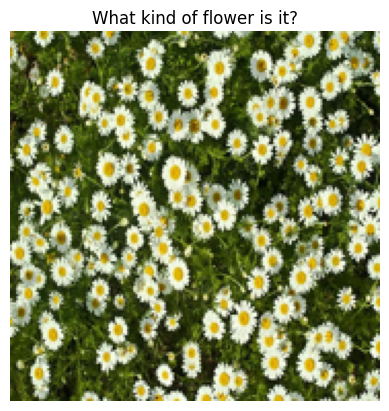

In [ ]:
img_path = daisy
img = keras.utils.load_img(img_path) # get the jpeg pictuire
img = Image.fromarray(array(img))
resized_img = img.resize((img_height, img_width))
plot_image(resized_img, "What kind of flower is it?")

In [ ]:
resized_img_array = expand_dims(array(resized_img), 0)
predictions = model.predict(resized_img_array)
score = nn.softmax(predictions[0])

print("This image most likely belongs to {} with a {:.2f} percent confidence." .format(class_names[argmax(score)], 100 * max(score)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
This image most likely belongs to daisy with a 87.33 percent confidence.
